In [211]:
##First few codeblocks are identical to the ones in training notebook, refer to that for comments

!pip install --quiet /kaggle/input/kerasapplications
!pip install --quiet /kaggle/input/efficientnet-git

In [212]:
import numpy as np
import pandas as pd 
import os

from PIL import Image
import matplotlib.pyplot as plt

import seaborn as sb

import tensorflow as tf
import math, re

from tensorflow import keras
from keras.models import load_model

from kaggle_datasets import KaggleDatasets
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from functools import partial

In [213]:
main_dir = '../input/cassava-leaf-disease-classification/'
os.listdir(main_dir) 
train_img_path = '../input/cassava-leaf-disease-classification/train_images'

In [214]:
#Detect TPU
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Device:', tpu.master())
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
except:
    strategy = tf.distribute.get_strategy()
print('Number of replicas:', strategy.num_replicas_in_sync)

Number of replicas: 1


In [215]:
# set up variables
AUTOTUNE = tf.data.experimental.AUTOTUNE
GCS_PATH = '/kaggle/input/cassava-leaf-disease-classification'                                                
IMAGE_SIZE = [512,512]
CLASSES = ['0', '1', '2', '3', '4']

t_1 = 0.6
t_2 = 1.4
SMOOTH_FRACTION = 0.1
N_ITER = 5

BATCH_SIZE = 16 * strategy.num_replicas_in_sync
EPOCHS = 30
input_shape = (512,512,3)
dropout_rate = 0.2

In [217]:
TRAINING_FILENAMES, VALID_FILENAMES = train_test_split(
    tf.io.gfile.glob(GCS_PATH + '/train_tfrecords/ld_train*.tfrec'),
    test_size=0.2, random_state=5
)

TEST_FILENAMES = tf.io.gfile.glob(GCS_PATH + '/test_tfrecords/ld_test*.tfrec')
TEST_FILENAMES

['/kaggle/input/cassava-leaf-disease-classification/test_tfrecords/ld_test00-1.tfrec']

# Functions for loading the data

In [218]:
#Decode the data
#turn the images into tensors
#normalize the image (get every pixel to have a value between 0 and 1)
def decode_image(image):
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.cast(image, tf.float32) / 255.0
    image = tf.reshape(image, [*IMAGE_SIZE, 3])
    return image

In [219]:
#setting up variables X and y; in this case image and prediction (for images with no label)
def read_tfrecord(example, labeled):
    tfrecord_format = {
        "image": tf.io.FixedLenFeature([], tf.string),
        "target": tf.io.FixedLenFeature([], tf.int64)
    } if labeled else {
        "image": tf.io.FixedLenFeature([], tf.string),
        "image_name": tf.io.FixedLenFeature([], tf.string)
    }
    example = tf.io.parse_single_example(example, tfrecord_format)
    image = decode_image(example['image'])
    if labeled:
        label = tf.cast(example['target'], tf.int32)
        return image, label
    idnum = example['image_name']
    return image, idnum

In [220]:
# the following code will load the dataset using the TPU
def load_dataset(filenames, labeled=True, ordered=False):
    ignore_order = tf.data.Options()
    if not ordered:
        ignore_order.experimental_deterministic = False # disable order, increase speed
    dataset = tf.data.TFRecordDataset(filenames, num_parallel_reads=AUTOTUNE) # automatically interleaves reads from multiple files
    dataset = dataset.with_options(ignore_order) # uses data as soon as it streams in, rather than in its original order
    dataset = dataset.map(partial(read_tfrecord, labeled=labeled), num_parallel_calls=AUTOTUNE)
    return dataset

In [221]:
#The following functions will be used to load our training, validation, and test datasets, as well as print out the number of images in each dataset.
def get_training_dataset():
    dataset = load_dataset(TRAINING_FILENAMES, labeled=True)  
#     dataset = dataset.map(data_augment, num_parallel_calls=AUTOTUNE)  
    dataset = dataset.repeat()
    dataset = dataset.shuffle(2048)
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.prefetch(AUTOTUNE)
    return dataset


def get_validation_dataset(ordered=False):
    dataset = load_dataset(VALID_FILENAMES, labeled=True, ordered=ordered) 
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.cache()
    dataset = dataset.prefetch(AUTOTUNE)
    return dataset



def get_test_dataset(ordered=False):
    dataset = load_dataset(TEST_FILENAMES, labeled=False, ordered=ordered)
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.prefetch(AUTOTUNE)
    return dataset


def count_data_items(filenames):
    n = [int(re.compile(r"-([0-9]*)\.").search(filename).group(1)) for filename in filenames]
    return np.sum(n)



NUM_TRAINING_IMAGES = count_data_items(TRAINING_FILENAMES)
NUM_VALIDATION_IMAGES = count_data_items(VALID_FILENAMES)
NUM_TEST_IMAGES = count_data_items(TEST_FILENAMES)


print('Dataset: {} training images, {} validation images, {} (unlabeled) test images'.format(
    NUM_TRAINING_IMAGES, NUM_VALIDATION_IMAGES, NUM_TEST_IMAGES))

# Loss Function (for loading the model)

In [223]:
# import module we'll need to import our custom module
from shutil import copyfile

# copy our file into the working directory (make sure it has .py suffix)
copyfile(src = "../input/bitempered-logistic-loss-tensorflow-v2/bi_tempered_loss.py", dst = "../working/loss.py")

# import all our functions
from loss import bi_tempered_logistic_loss

In [224]:
 class BiTemperedLogisticLoss(tf.keras.losses.Loss):
    def __init__(self, t1, t2, lbl_smth, n_iter):
      super(BiTemperedLogisticLoss, self).__init__()
      self.t1 = t1
      self.t2 = t2
      self.lbl_smth = lbl_smth
      self.n_iter = n_iter

    def call(self, y_true, y_pred):
      return bi_tempered_logistic_loss(y_pred, y_true, self.t1, self.t2, self.lbl_smth, self.n_iter)

# Loading the model

FOR ENSEMBLENCE

In [226]:
#If we are using a ensemble of models, uncomment this cell and load each saved model in the range

# nets = 5 
# model = [0] * nets

# for index in range (nets):
#     model[index] = load_model('/kaggle/input/bitemperedaug/model(withBitemp) (1).h5',
#                    custom_objects={'loss': BiTemperedLogisticLoss(t1=t_1, 
#                                                                   t2=t_2, 
#                                                                   lbl_smth=SMOOTH_FRACTION, 
#                                                                   n_iter=N_ITER)}, 
#                    compile=False)

FOR SINGLE MODEL

In [227]:
model = load_model('/kaggle/input/bitemperedaug/model(withBitemp) (1).h5', #If we are using a single model, use this cell
                   custom_objects={'loss': BiTemperedLogisticLoss(t1=t_1, 
                                                                  t2=t_2, 
                                                                  lbl_smth=SMOOTH_FRACTION, 
                                                                  n_iter=N_ITER)}, 
                   compile=False)

# Preparing predictions

In [228]:
def to_float32(image, label):
    return tf.cast(image, tf.float32), label #Cast our images to float32 dtype

test_dataset = get_test_dataset() #Set our testing dataset

test_ds = get_test_dataset(ordered=True) 
test_ds = test_ds.map(to_float32)

test_images_ds = test_dataset
test_images_ds = test_ds.map(lambda image, idnum: image)

# Predictions

FOR ENSEMBLENCE

In [229]:
###Same as above, if using an ensemble uncomment this, lets all of the models in the ensemble generate predictions and we use the highest probability one

# #Result
# results = np.zeros( (int(NUM_TEST_IMAGES),5) ) 

# for index in range(nets):
#     #each model gives its predictions
#     results = results + model[index].predict(test_images_ds)
 
# #Finding the best prediction 
# predictions = np.argmax(results,axis = 1)

FOR SINGLE MODELS

In [230]:
probabilities = model.predict(test_images_ds)# If using a single model use this, works the same as above cell but for only one model
predictions = np.argmax(probabilities, axis=-1)

# Submission File

In [231]:
print('Generating submission.csv file...')
test_ids_ds = test_ds.map(lambda image, idnum: idnum).unbatch()
test_ids = next(iter(test_ids_ds.batch(NUM_TEST_IMAGES))).numpy().astype('U') # all in one batch
np.savetxt('submission.csv', np.rec.fromarrays([test_ids, predictions]), fmt=['%s', '%d'], delimiter=',', header='image_id,label', comments='')
!head submission.csv #Save our submission csv file with a prediction and model to submit to kaggle competiton

Generating submission.csv file...
image_id,label
2216849948.jpg,4


# Visualization

In [232]:
train_dataset = get_training_dataset()
valid_dataset = get_validation_dataset()

In [233]:
NUM_TRAINING_IMAGES = count_data_items(TRAINING_FILENAMES)
NUM_VALIDATION_IMAGES = count_data_items(VALID_FILENAMES)
NUM_TEST_IMAGES = count_data_items(TEST_FILENAMES)

In [238]:
def take_higher_value_index (array2D):###Show us how our model makes predictions, print probability for each label
    max_value = np.max(array2D)
    index_of_array, index_in_array = np.where(array2D == max_value)
    return "the largest probability is {} in the model/array that has index {} and the label chosen by the model is {}".format(round(max_value,2), index_of_array, index_in_array)

def graph_prob(array, sub): #Graph the probability of each label
    values = array
    names = ['0','1', '2', '3','4']
    plt.figure(figsize=(24, 6))
    plt.subplot(141+sub)
    plt.bar(names, values)
    return plt.show()

def graph_2D(array2D):
    for i, array in enumerate(array2D):
        graph_prob(array,i)

def dataset_to_numpy_util(dataset, N): # Convert our dataset to a numpy format for visualization
    dataset = dataset.unbatch().batch(N)
    for images, labels in dataset:
        numpy_images = images.numpy()
        numpy_labels = labels.numpy()
        break;  
    return numpy_images, numpy_labels

def title_from_label_and_target(label, correct_label): # Helper function to display predicted label and actual label from dataset
    label = np.argmax(label, axis=-1)
    correct = (label == correct_label)
    return "{} [{}{}{}]".format(label, str(correct), ', shoud be ' if not correct else '',
                                correct_label if not correct else ''), correct

def display_one_flower_eval(image, title, subplot, red=False):#Display one image with the predicted label
    plt.subplot(subplot)
    plt.axis('off')
    plt.imshow(image)
    plt.title(title, fontsize=14, color='red' if red else 'black')
    return subplot+1

def display_9_images_with_predictions(images, predictions, labels):#Display 9 images with the predicted label
    subplot=331
    plt.figure(figsize=(13,13))
    for i, image in enumerate(images):
        title, correct = title_from_label_and_target(predictions[i], labels[i])
        subplot = display_one_flower_eval(image, title, subplot, not correct)
        if i >= 8:
            break;
              
    plt.tight_layout()
    plt.subplots_adjust(wspace=0.1, hspace=0.1)
    plt.show()

In [240]:
take_higher_value_index(results)
graph_2D(results)

'the largest probability is 0.0 in the model/array that has index [0 0 0 0 0] and the label chosen by the model is [0 1 2 3 4]'

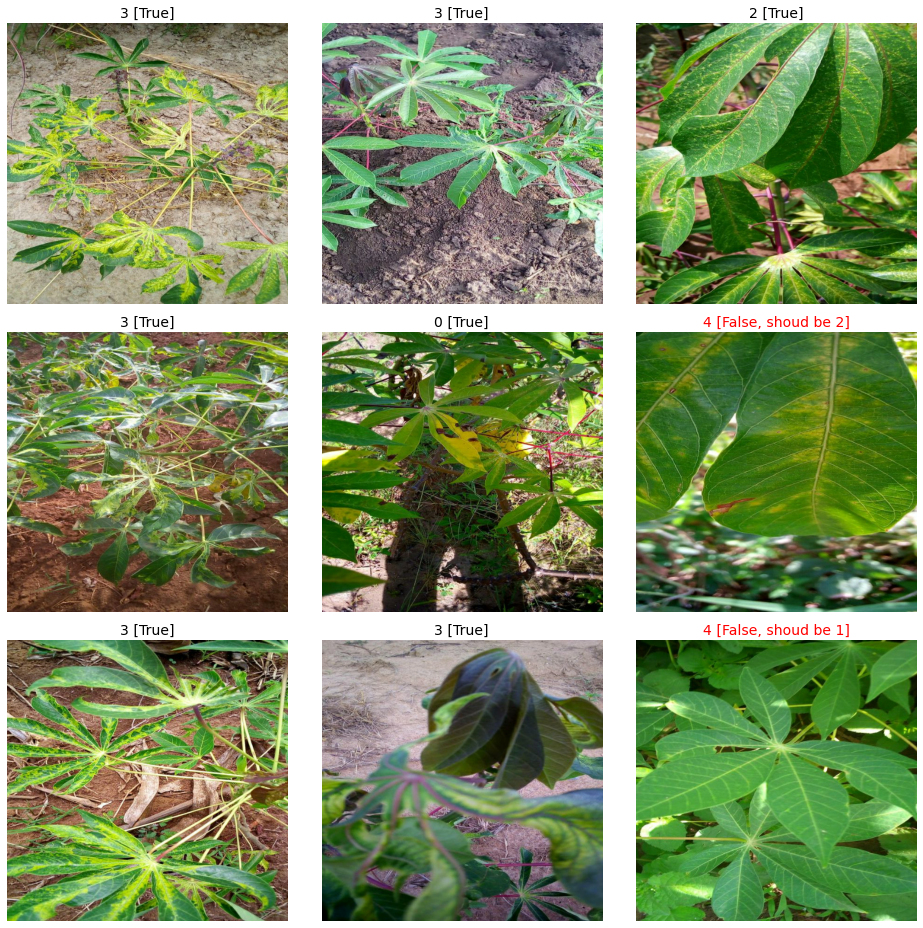

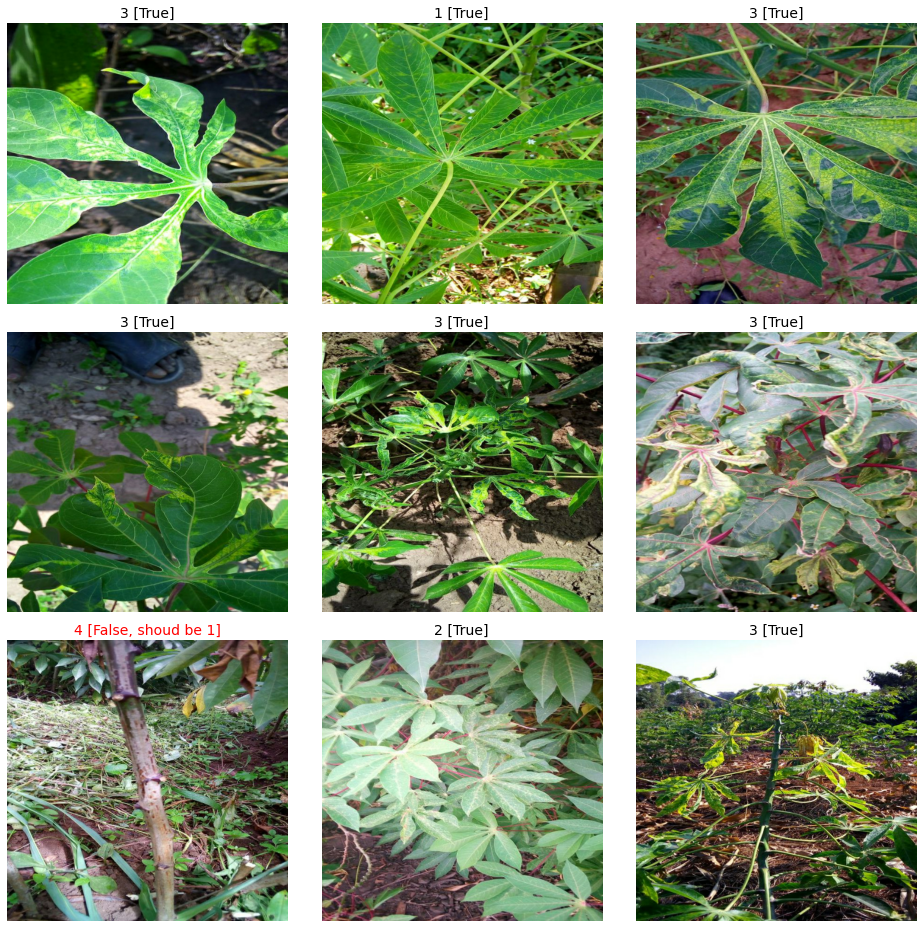

In [243]:
###Show us some predictions
x_samp, y_samp = dataset_to_numpy_util(valid_dataset, 18)

x_samp_1, y_samp_1 = x_samp[:9,:,:,:], y_samp[:9]
samp_preds_1 = model.predict(x_samp_1, batch_size=9)
display_9_images_with_predictions(x_samp_1, samp_preds_1, y_samp_1)

x_samp_2, y_samp_2 = x_samp[9:,:,:,:], y_samp[9:]
samp_preds_2 = model.predict(x_samp_2, batch_size=9)
display_9_images_with_predictions(x_samp_2, samp_preds_2, y_samp_2)